# University of Waterloo Student Housing and Venue Capstone Project

By: Jacob Rintjema

Date: November 2020

---

# Introduction & Description of the Background

The University of Waterloo (commonly referred to as Waterloo, UW, or UWaterloo) is a public research university with a main campus in Waterloo, Ontario, Canada. The main campus is on 404 hectares (998 acres) of land adjacent to "Uptown" Waterloo and Waterloo Park. The university also operates three satellite campuses and four affiliated university colleges. The university offers academic programs administered by six faculties and thirteen faculty-based schools. Waterloo operates the largest post-secondary co-operative education program in the world, with over 20,000 undergraduate students enrolled in the university's co-op program. The university is a co-educational institution, with approximately 41,000 undergraduate and 6,900 postgraduate students enrolled there in 2019.

The focus of this project is to provide housing rental and purchashing options for students on and off campus. For incoming students, (especially international level), there is always stress and difficulties involved finding housing. This service will provide affordable options that tailor towards housing near the university campus. Students will get situated easier and will be able to focus more on their studies instead. The service will leverage Four Square API data to support this.

# Data Description

The project will provide:
 - Housing data from the Realtor - Canadian Real Estate API, Ex. Housing options within a 2 km range from campus.
 - Nearby venue options using the Four Square API, Ex. Shopping centres, restaurants and bars nearby.
 - Location of housing using GeoPy, Ex: Longitude and latitude coordinates of housing.
 
Students will be able to view housing locations as well as close by venues that are in range of the University of Waterloo campus.

Data Needed:
 - Realtor API Data
 - GeoPy Location Data
 - Four Square API Data
 - Waterloo Geo Boundaries

# Resources

 - [Realtor API](https://rapidapi.com/apidojo/api/realtor-canadian-real-estate?endpoint=apiendpoint_b55bd49d-f8a8-4728-a397-c74a56d9d921)
 - [Four Square API](https://developer.foursquare.com)
 - [Waterloo Geo Boundaries](https://data.waterloo.ca/datasets/RMW::regional-boundaries-1/geoservice?geometry=-81.519%2C43.295%2C-79.541%2C43.644)

---

# Library Imports

In [112]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from matplotlib.pylab import plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
!pip install folium
import folium
from math import cos, asin, sqrt, pi
import seaborn as sns
print('Libraries imported.')

Libraries imported.


# Function to leverage Realtor API to find apartments

In [113]:
def get_housing():
    url = "https://realtor.p.rapidapi.com/properties/v2/list-for-rent"
    housing_list = []

    querystring = {
        "city":"Waterloo",
        "state_code":"ON",
        "limit":"200",
        "offset":"0",
        "sort":"relevance"
    }

    headers = {
        'x-rapidapi-key': "df43aef8c0msh490214556e0f743p1a83ebjsn5db4866daa48",
        'x-rapidapi-host': "realtor.p.rapidapi.com"
        }

    response = requests.request("GET", url, headers=headers, params=querystring).json()['properties']
    
    housing_list.append([(
        house['address']['line'],
        house['address']['postal_code'],
        house['address']['lat'],
        house['address']['lon'],
        house['price'],
        house['rdc_web_url']) for house in response])

    # Apartment dataframe
    houses_for_rent = pd.DataFrame([house for housing_list in housing_list for house in housing_list])

    # Apartment columns
    houses_for_rent.columns = ['Address', 'Postal Code', 'Latitude', 'Longitude', 'Price', 'Listing Link']


    return houses_for_rent

In [114]:
housing_df = get_housing()

In [115]:
housing_df

,Address,Postal Code,Latitude,Longitude,Price,Listing Link
0,A4-308 Hawthorn St,N2L 3J1,43.47837,-80.52761,530,https://www.realtor.com/realestateandhomes-det...
1,401-34 Laurel St,N2J 2H2,43.46708,-80.51806,500,https://www.realtor.com/realestateandhomes-det...
2,306-34 Laurel St,N2J 2H2,43.46708,-80.51806,530,https://www.realtor.com/realestateandhomes-det...
3,305-34 Laurel St,N2J 2H2,43.46708,-80.51806,530,https://www.realtor.com/realestateandhomes-det...
4,602-34 Laurel St,N2J 2H2,43.46708,-80.51806,500,https://www.realtor.com/realestateandhomes-det...
5,7-40 Laurel St,N2J 2H2,43.46730,-80.51776,500,https://www.realtor.com/realestateandhomes-det...
6,121N5-121 Noecker St,N2J 2R9,43.47316,-80.51620,500,https://www.realtor.com/realestateandhomes-det...


# Visualize out Waterloo housing on Folium Map

In [116]:
def map_housing():
    waterloo_lat = 43.471585
    waterloo_long = -80.544044
    waterloo_map = folium.Map(location=[waterloo_lat, waterloo_long], zoom_start=15)
    
    # University Marker
    folium.Marker(location=[waterloo_lat, waterloo_long], 
                  popup=(folium.Popup('University of Waterloo')),
                  icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(waterloo_map)



    # Add markers to map
    for lat, lng, address, price in zip(housing_df['Latitude'], housing_df['Longitude'], 
                                housing_df['Address'], housing_df['Price']):
        
        # Label the map
        label = '{}, ${}'.format(address, price)
        label = folium.Popup(label, parse_html=True)
        
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(waterloo_map)
    
    # Return map
    return waterloo_map

In [117]:
waterloo_map = map_housing()
waterloo_map

# Get Distance from Waterloo Campus

In [118]:
# Returns distance between coordinates (in Kilometers)
def distance(lat, lon):
    # UWaterloo Lat and Long Coordinates
    waterloo_lat = 43.471585
    waterloo_long = -80.544044
    p = pi/180
    a = 0.5 - cos((waterloo_lat-lat)*p)/2 + cos(lat*p) * cos(waterloo_lat*p) * (1-cos((waterloo_long-lon)*p))/2
    return 12742 * asin(sqrt(a))

In [119]:
housing_df['Distance'] = ''

In [120]:
for i in range(0, housing_df.shape[0]):
    housing_df['Distance'][i] = distance(housing_df['Latitude'][i], housing_df['Longitude'][i])

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [121]:
housing_df

,Address,Postal Code,Latitude,Longitude,Price,Listing Link,Distance
0,A4-308 Hawthorn St,N2L 3J1,43.47837,-80.52761,530,https://www.realtor.com/realestateandhomes-det...,1.52568
1,401-34 Laurel St,N2J 2H2,43.46708,-80.51806,500,https://www.realtor.com/realestateandhomes-det...,2.15589
2,306-34 Laurel St,N2J 2H2,43.46708,-80.51806,530,https://www.realtor.com/realestateandhomes-det...,2.15589
3,305-34 Laurel St,N2J 2H2,43.46708,-80.51806,530,https://www.realtor.com/realestateandhomes-det...,2.15589
4,602-34 Laurel St,N2J 2H2,43.46708,-80.51806,500,https://www.realtor.com/realestateandhomes-det...,2.15589
5,7-40 Laurel St,N2J 2H2,43.46730,-80.51776,500,https://www.realtor.com/realestateandhomes-det...,2.17394
6,121N5-121 Noecker St,N2J 2R9,43.47316,-80.51620,500,https://www.realtor.com/realestateandhomes-det...,2.25368


# Get Waterloo Venue Info from Four Square API

In [122]:
def get_venues(address, latitudes, longitudes, price, radius=804.672):

    CLIENT_ID = 'ODLNKXPTHFKX35S0BYNFOWHSUNZAWXO1PEGGZSGPIINPVLDF'  
    CLIENT_SECRET = '3HUSDO1PQROPEUC5LO2J0FPEVHAKHJ1HHIXKW4RR2RRBBK1P' 
    VERSION = '20180605'
    LIMIT = 100

    # Venues list
    venues_list = []

    # Get the venues nearby for each apartment
    for addrss, lat, lng, pr in zip(address, latitudes, longitudes, price):

        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # Return only relevant information for each nearby venue
        venues_list.append([(
            addrss,
            lat,
            lng,
            pr,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    # Venues dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    # Venues columns
    nearby_venues.columns = ['Address',
                             'Latitude',
                             'Longitude',
                             'Price',
                             'Venue',
                             'Venue Lat',
                             'Venue Long',
                             'Venue Type']

    # Return venues
    return nearby_venues

In [123]:
venues_df = get_venues(housing_df['Address'], housing_df['Latitude'], housing_df['Longitude'], housing_df['Price'])

# Visualize out Waterloo Venues on Folium Map

In [124]:
def map_venues():
    waterloo_lat = 43.471585
    waterloo_long = -80.544044
    waterloo_venues_map = folium.Map(location=[43.470934, -80.523721], zoom_start=15)
    
    # University Marker
    folium.Marker(location=[waterloo_lat, waterloo_long], 
                  popup=(folium.Popup('University of Waterloo')),
                  icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(waterloo_venues_map)



    # Add markers to map
    for lat, lng, venues, venues_category in zip(venues_df['Venue Lat'], venues_df['Venue Long'], 
                                venues_df['Venue'], venues_df['Venue Type']):
        
        # Label the map
        label = '{}, {}'.format(venues, venues_category)
        label = folium.Popup(label, parse_html=True)
        
        # Make circle in the map for each neighborhood
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(waterloo_venues_map)
    
    # Return map
    return waterloo_venues_map

In [125]:
waterloo_venues_map = map_venues()
waterloo_venues_map

# Calculate number of venues per location

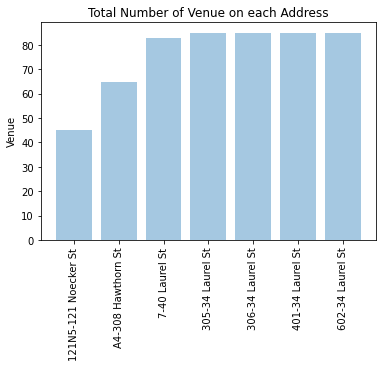

In [126]:
# Group each value by the address and add the count for each venues
value_count = venues_df.groupby('Address').count().reset_index()
value_count['Count'] = value_count['Venue']

# Drop the column that I'm not going to use 
value_count = value_count.drop(['Price','Latitude', 'Longitude', 'Venue', 'Venue Lat', 'Venue Long','Venue Type'], axis=1)
value_count = value_count.sort_values('Count').reset_index(drop=True)
value_count.head()


# Graph axis
objects = value_count.Address
y_pos = np.arange(len(objects))
performance = value_count.Count

# Plot the total number of venues for each zipcode
plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venues per Addresss')
plt.xticks(rotation=90)

# Show graph
plt.show()

# Compare Distance (KM) to price (CAD) of each rental

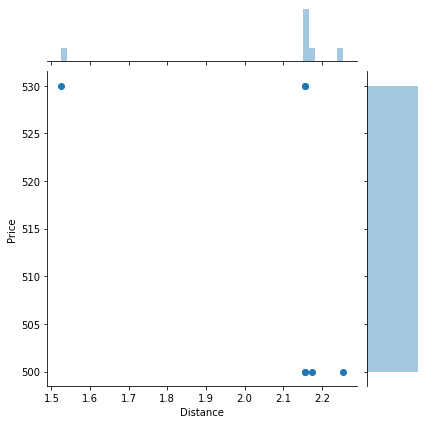

In [127]:
sns.jointplot(x='Distance', y='Price', data=housing_df[['Distance', 'Price']])

# One-hot Encoding of Venues

In [129]:
one_hot_venues = venues_df

# One hot encoding
one_hot_venues = pd.get_dummies(venues_df[['Venue Type']], prefix="", prefix_sep="")
# Insert Address
one_hot_venues.insert(loc=0, column='Address', value=venues_df['Address'])

one_hot_venues

,Address,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Café,Chinese Restaurant,Coffee Shop,College Cafeteria,College Gym,Convenience Store,Diner,Doctor's Office,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gas Station,Gastropub,German Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Liquor Store,Locksmith,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Music Venue,Nail Salon,Nightclub,Optical Shop,Paper / Office Supplies Store,Pharmacy,Pizza Place,Plaza,Poutine Place,Pub,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,School,Shopping Mall,Skating Rink,Smoothie Shop,Spa,Sporting Goods Shop,Steakhouse,Szechuan Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,A4-308 Hawthorn St,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,A4-308 Hawthorn St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Find frequency of each type of venue

In [130]:
venue_frequency = one_hot_venues.groupby('Address').mean().reset_index()
venue_frequency

,Address,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Café,Chinese Restaurant,Coffee Shop,College Cafeteria,College Gym,Convenience Store,Diner,Doctor's Office,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gas Station,Gastropub,German Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Liquor Store,Locksmith,Martial Arts School,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Music Venue,Nail Salon,Nightclub,Optical Shop,Paper / Office Supplies Store,Pharmacy,Pizza Place,Plaza,Poutine Place,Pub,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,School,Shopping Mall,Skating Rink,Smoothie Shop,Spa,Sporting Goods Shop,Steakhouse,Szechuan Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,121N5-121 Noecker St,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.022222,0.022222,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.022222,0.022222,0.044444,0.111111,0.000000,0.000000,0.022222,0.022222,0.022222,0.022222,0.000000,0.022222,0.022222,0.022222,0.000000,0.000000,0.044444,0.000000,0.000000,0.022222,0.022222,0.000000,0.022222,0.022222,0.022222,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.022222,0.000000,0.022222,0.022222,0.000000,0.022222,0.088889,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.000000
1,305-34 Laurel St,0.011765,0.023529,0.023529,0.000000,0.011765,0.023529,0.047059,0.011765,0.023529,0.023529,0.011765,0.000000,0.000000,0.000000,0.000000,0.058824,0.023529,0.058824,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765,0.011765,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.000000,0.035294,0.000000,0.000000,0.000000,0.000000,0.023529,0.023529,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.000000,0.011765,0.000000,0.011765,0.000000,0.011765,0.000000,0.023529,0.047059,0.011765,0.000000,0.011765,0.011765,0.058824,0.011765,0.023529,0.011765,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765,0.000000,0.011765,0.023529,0.000000,0.011765,0.011765,0.000000,0.000000,0.011765
2,306-34 Laurel St,0.011765,0.023529,0.023529,0.000000,0.011765,0.023529,0.047059,0.011765,0.023529,0.023529,0.011765,0.000000,0.000000,0.000000,0.000000,0.058824,0.023529,0.058824,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765,0.011765,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.000000,0.035294,0.000000,0.000000,0.000000,0.000000,0.023529,0.023529,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.000000,0.011765,0.000000,0.011765,0.000000,0.011765,0.000000,0.023529,0.047059,0.011765,0.000000,0.011765,0.011765,0.058824,0.011765,0.023529,0.011765,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765,0.000000,0.011765,0.023529,0.000000,0.011765,0.011765,0.000000,0.000000,0.011765
3,401-34 Laurel St,0.011765,0.023529,0.023529,0.000000,0.011765,0.023529,0.047059,0.011765,0.023529,0.023529,0.011765,0.000000,0.000000,0.000000,0.000000,0.058824,0.023529,0.058824,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765,0.011765,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.000000,0.035294,0.000000,0.000000,0.000000,0.000000,0.023529,0.023529,0.011765,0.000000,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.000000,0.011765,0.

# Create Columns According to Number of Top Venues¶

# Find Optimal K for K-means Clustering

# Applying Clustering algorithm